<h1 align=center><font size = 5>Segmenting and Clustering Neighbourhoods in Toronto</font></h1>

<hr>

### **_Please note that all three parts are herein included. They are presented as you scroll down the code (numbered)!_**

## Table of Contents

1 - <a href="#item1">Part 1: Scraping and Cleaning Data</a>

2 - <a href="#item2">Part 2: Getting Coordinates</a>  

3 - <a href="#item3">Part 3: Neighbourhood Clustering and Exploring</a>   

<a id="item1"></a>

### **1 - Scraping and Cleaning Data**

##### Since the city of Toronto has its postal codes all starting with the letter M, we'll search of the list of postal codes starting with M on Wikipedia's page.

#### Importing libraries

##### In order to scrape that website the libraries *urllib* and _BeautifulSoup **(bs4)**_ will be used.

In [1]:
# Installing bs4 package
# !conda install -c anaconda beautifulsoup4 --yes
# !conda install -c anaconda lxml --yes

In [2]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

#### Downloading the web page

##### The HTML Document will be requested from web.

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page = urlopen(url) 
page

#### Parsing HTML

##### HTML Document downloaded above will be parsed to BeautifulSoup instance.

In [4]:
bs = BeautifulSoup(page, 'lxml')

##### Now that's better to look for the desired table and it was found to be _\<table class="wikitable"\>_

##### Next step is to get that table only.

In [5]:
table = bs.find('table', {"class": "wikitable"})

##### Creating function for accessing data from rows.

In [6]:
def get_row_data(tr, tag='td'): # td for data or th for header       
        return [td.get_text(strip=True) for td in tr.find_all(tag)]

##### Getting rows into a list.

In [7]:
rows = []
trs = table.find_all('tr')
header = get_row_data(trs[0], 'th')
for tr in trs:
    rows.append(get_row_data(tr, 'td'))

print("Header row: ", header)
print("Data row: ", rows[:5])

Header row:  ['Postal code', 'Borough', 'Neighborhood']
Data row:  [[], ['M1A', 'Not assigned', ''], ['M2A', 'Not assigned', ''], ['M3A', 'North York', 'Parkwoods'], ['M4A', 'North York', 'Victoria Village']]


#### Transforming into a _pandas.DataFrame_

##### Since _row[0]_ from the list _rows_ is empty, we pass to the DataFrame from _row[1]_ and so on.

In [8]:
import pandas as pd

df = pd.DataFrame(rows[1:], columns=header)
df.head()

,Postal code,Borough,Neighborhood
0,M1A,Not assigned,
1,M2A,Not assigned,
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront


#### Cleaning Data

##### - Only process the cells that have an assigned borough. Ignore cells with a borough that is **Not assigned**.

In [9]:
import numpy as np

df.replace(['Not assigned'], np.nan, inplace=True)
df.dropna(subset=['Borough'], axis='index', inplace=True)
df.reset_index(inplace=True, drop=True)
df.head()

,Postal code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Regent Park / Harbourfront
3,M6A,North York,Lawrence Manor / Lawrence Heights
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government


##### - More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that **M5A** is listed twice and has two neighborhoods: **Harbourfront** and **Regent Park**. These two rows will be combined into one row with the neighborhoods separated with a comma.

In [10]:
df['Neighborhood'] = df['Neighborhood'].str.replace("/", ",")
df.head()

,Postal code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park , Harbourfront"
3,M6A,North York,"Lawrence Manor , Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government"


##### - If a cell has a borough but a **Not assigned** neighborhood, then the neighborhood will be the same as the borough.

In [11]:
df['Neighborhood'].replace('Not assigned', np.nan)
df['Neighborhood'].replace('', np.nan)
df['Neighborhood'].isna().value_counts()

False    103
Name: Neighborhood, dtype: int64

##### As it seems, there are no Neighborhood fields (rows) filled with *Not assigned* 

##### - In the last cell of your notebook, use the **.shape** method to print the number of rows of your dataframe.

In [12]:
df.shape

(103, 3)

<a id="item2"></a>

<hr>

### **2 - Getting Neighbourhoods Coordinates**

### Postal Codes Coordinates

##### Accessing coordinates from a CSV file due to charging API's issues.

In [13]:
!wget --quiet -O 'postal_coords.csv' 'http://cocl.us/Geospatial_data'

##### Reading from CSV file.

In [14]:
import pandas as pd

df_coords = pd.read_csv('postal_coords.csv')
df_coords.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


##### Checking if it has the same number of rows as _df_

In [15]:
print('#rows df: ', df.shape)
print('#rows df_coords', df_coords.shape)

#rows df:  (103, 3)
#rows df_coords (103, 3)


##### Let's set both headers equal

In [16]:
df = df.rename(columns={'Postal code': 'Postal Code'})
df.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park , Harbourfront"
3,M6A,North York,"Lawrence Manor , Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government"


##### Since it has the same length and same headers it's to merge both dataframes into one.  

In [17]:
df = pd.merge(df, df_coords, on='Postal Code')
df.head(10)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,Scarborough,"Malvern , Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill , Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


##### _Dataframe all set up!_

<a id='#item3'></a>

<hr>

### **3 - Neighbourhood Clustering and Exploring**

### Creating Toronto Map

##### We'll create a map visualization with _Folium_ library. Toronto coordinates were found on <a>https://www.latlong.net/place/toronto-on-canada-27230.html</a> on Apr 4th, 2020 when this part of this notebook has been written.

In [18]:
import folium

print(" folium imported!")

toronto_lat  = 43.651070
toronto_long = -79.347015

toronto_map = folium.Map(location=[toronto_lat, toronto_long], zoom_start=10)
toronto_map

 folium imported!


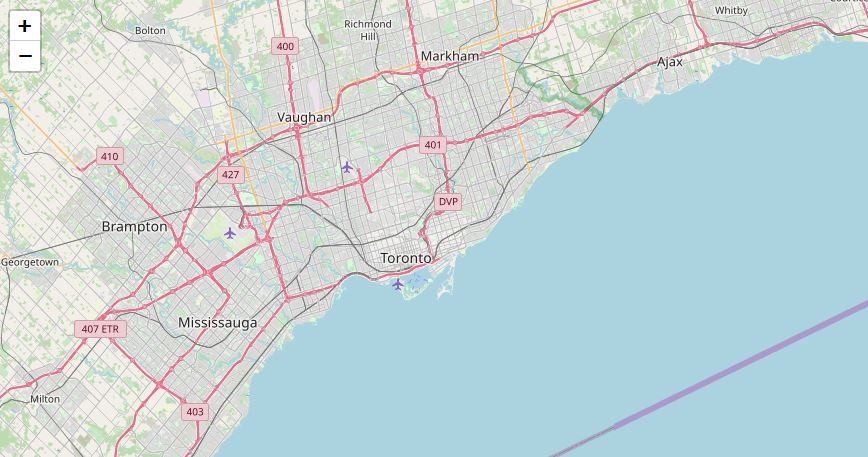

In [19]:
# Screenshot of the map created above
from IPython.display import Image
Image("toronto_1.JPG")

##### Since the map of Toronto can be visualized well, some markers will be added to it. It would be better if the most dense boroughs were 

##### taken in consideration in order to clean up the map first.

In [20]:
df['Borough'].value_counts()

North York          24
Downtown Toronto    19
Scarborough         17
Etobicoke           12
Central Toronto      9
West Toronto         6
York                 5
East York            5
East Toronto         5
Mississauga          1
Name: Borough, dtype: int64

##### Taking most dense boroughs

In [21]:
df_clean = df[df['Borough'].str.contains('Downtown Toronto')]
df_clean = df_clean.append(df[df['Borough'].str.contains('North York')])
df_clean = df_clean.append(df[df['Borough'].str.contains('Scarborough')])
df_clean = df_clean.append(df[df['Borough'].str.contains('Etobicoke')])
df_clean['Borough'].value_counts()

North York          24
Downtown Toronto    19
Scarborough         17
Etobicoke           12
Name: Borough, dtype: int64

##### Adding markers to the map

In [22]:
for lat, lng, label in zip(df_clean['Latitude'],df_clean['Longitude'], df_clean['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='b',
        fill_opacity=0.5,
        parse_html=False).add_to(toronto_map)  
    
toronto_map

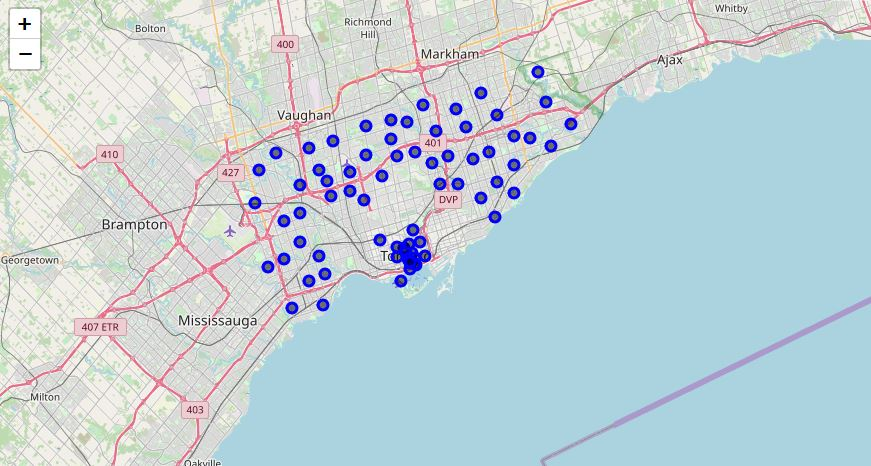

In [23]:
# Screenshot of the map created above
from IPython.display import Image
Image("toronto_2.JPG")

#### Accessing Toronto Venues Data

##### The Foursquare API will be used for getting nearby venues information. So let the Foursquer credentials be set.

In [24]:
CLIENT_ID = 'G4GBDV14K54YLSHYVEJZ5QEN4GERHVNPRX20PT0EAHFMGTA4' # Intentionally deleted
CLIENT_SECRET = 'ITXUTVTS2ERZQJZXURTQJCTKJ1ZW3H33WWE23NOIGKGMJSCJ' # Intentionally deleted
VERSION = '20180604'
LIMIT=50 # limit of number of venues returned by Foursquare API
radius=500 # define radius

##### The function _getNearbyVenues()_ has been provided in the lab and will be very useful here.

In [25]:
import json
import requests
print("Libraries imported")

Libraries imported


In [26]:
def getNearbyVenues(names, latitudes, longitudes, radius=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

##### Getting venues for each neighbourhood 

In [27]:
df_venues = getNearbyVenues(names=df_clean['Neighborhood'], latitudes=df_clean['Latitude'], longitudes=df_clean['Longitude'])


Regent Park , Harbourfront
Queen's Park , Ontario Provincial Government
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Christie
Richmond , Adelaide , King
Harbourfront East , Union Station , Toronto Islands
Toronto Dominion Centre , Design Exchange
Commerce Court , Victoria Hotel
University of Toronto , Harbord
Kensington Market , Chinatown , Grange Park
CN Tower , King and Spadina , Railway Lands , Harbourfront West , BathurstQuay , South Niagara , Island airport
Rosedale
Stn A PO Boxes
St. James Town , Cabbagetown
First Canadian Place , Underground city
Church and Wellesley
Parkwoods
Victoria Village
Lawrence Manor , Lawrence Heights
Don Mills
Glencairn
Don Mills
Hillcrest Village
Bathurst Manor , Wilson Heights , Downsview North
Fairview , Henry Farm , Oriole
Northwood Park , York University
Bayview Village
Downsview
York Mills , Silver Hills
Downsview
North Park , Maple Leaf Park , Upwood Park
Humber Summit
Willowdale , Newtonbrook
Downsview
Bedford Park , L

##### Checking out how many venues for each neighbourhood were returned

In [28]:
df_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Bathurst Manor , Wilson Heights , Downsview North",3,3,3,3,3,3
"Bedford Park , Lawrence Manor East",4,4,4,4,4,4
"CN Tower , King and Spadina , Railway Lands , Harbourfront West , BathurstQuay , South Niagara , Island airport",1,1,1,1,1,1
Central Bay Street,4,4,4,4,4,4
Christie,1,1,1,1,1,1


##### One Hot Encoding for Venues Category

In [29]:
df_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

##### Adding original _Neighborhood_ column to one hot encoded one and moving _Neighbourhood_ to the first column of the dataframe

In [30]:
df_onehot['Neighbourhood'] = df_venues['Neighborhood']
fix = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fix]
df_onehot.head()

,Neighbourhood,Accessories Store,American Restaurant,Art Gallery,Bakery,Bank,Bar,Baseball Field,Bookstore,Boutique,...,Seafood Restaurant,Soup Place,Spa,Sushi Restaurant,Taco Place,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Vegetarian / Vegan Restaurant
0,"Regent Park , Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,"Regent Park , Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park , Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Garden District, Ryerson",0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Garden District, Ryerson",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
df_onehot.shape

(111, 63)

##### Grouping rows by Neighbourhood

In [32]:
df_grouped = df_onehot.groupby('Neighbourhood').mean().reset_index()
df_grouped.head()

,Neighbourhood,Accessories Store,American Restaurant,Art Gallery,Bakery,Bank,Bar,Baseball Field,Bookstore,Boutique,...,Seafood Restaurant,Soup Place,Spa,Sushi Restaurant,Taco Place,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Vegetarian / Vegan Restaurant
0,"Bathurst Manor , Wilson Heights , Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
1,"Bedford Park , Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0
2,"CN Tower , King and Spadina , Railway Lands , ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
3,Central Bay Street,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
4,Christie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0


##### Comparing the original dataset with the onehot encoded one. Both are grouped by neighbourhoods but the second one has been shrunk

In [33]:
print("Shape of df: " , df.shape)
print("Shape of df_grouped: ", df_grouped.shape)

Shape of df:  (103, 5)
Shape of df_grouped:  (26, 63)


#### Clustering

##### By now the clustering part of the code must take turn.

##### Importing library

In [34]:
from sklearn.cluster import KMeans

##### The column _Neighbourhood_ must be dropped for clustering

In [35]:
df_cluster = df_grouped.drop('Neighbourhood', axis=1)
df_cluster.head()

,Accessories Store,American Restaurant,Art Gallery,Bakery,Bank,Bar,Baseball Field,Bookstore,Boutique,Breakfast Spot,...,Seafood Restaurant,Soup Place,Spa,Sushi Restaurant,Taco Place,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Vegetarian / Vegan Restaurant
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0


##### Training KMeans model with k set to 4 such as the number of boroughs included in dataframe

In [36]:
k = 4

kmeans = KMeans(n_clusters = k, random_state = 0).fit(df_cluster)
kmeans.labels_

array([0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0,
       0, 0, 0, 2], dtype=int32)

#### Visualizing Clustered Data

##### Merging _df_grouped_ unto _df_ 

In [37]:
df_toronto=pd.merge(df, df_grouped, how='left', left_on='Neighborhood', right_on='Neighbourhood')
df_toronto.drop('Neighbourhood', axis=1, inplace=True)
df_toronto.rename(columns={'Neighborhood_x':'Neighbourhood'}, inplace=True)

In [38]:
df_toronto.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Accessories Store,American Restaurant,Art Gallery,Bakery,Bank,...,Seafood Restaurant,Soup Place,Spa,Sushi Restaurant,Taco Place,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Vegetarian / Vegan Restaurant
0,M3A,North York,Parkwoods,43.753259,-79.329656,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,M4A,North York,Victoria Village,43.725882,-79.315572,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763,0.25,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Adding cluster labels to _df_toronto_

In [39]:
df_cluster['Cluster'] = kmeans.labels_
df_cluster.dtypes

Accessories Store                float64
American Restaurant              float64
Art Gallery                      float64
Bakery                           float64
Bank                             float64
                                  ...   
Thai Restaurant                  float64
Theater                          float64
Thrift / Vintage Store           float64
Vegetarian / Vegan Restaurant    float64
Cluster                            int32
Length: 63, dtype: object

In [40]:
df_toronto.shape

(103, 67)

##### Creating a map for the clustered data

In [41]:
cluster_map = folium.Map(location=[toronto_lat, toronto_long], zoom_start=10)

##### Setting colours scheme

In [42]:
colours = ['red', 'green', 'blue', 'yellow']

##### Finally adding the markers to the map

In [45]:
for latitude, longitude, neigh, cluster in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Neighborhood'],
                                                 df_cluster['Cluster']):
    label = folium.Popup(neigh, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=colours[cluster],
        fill_opacity=0.7).add_to(cluster_map)  

cluster_map

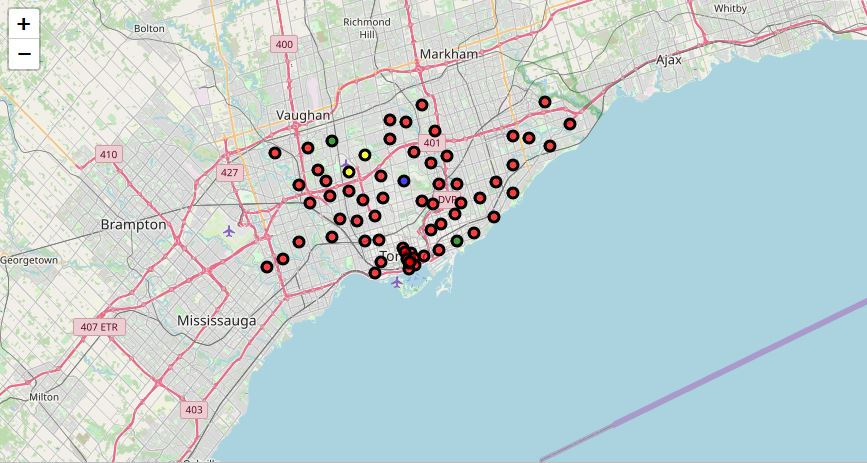

In [46]:
# Screenshot of the map created above
from IPython.display import Image
Image("toronto_3.JPG")